# Clustering over multi-session concatenation

In [1]:
import datajoint as dj
dj.config['display.limit'] = 10
dj.config['database.host'] = 'datajoint.it.ntnu.no'
dj.conn()

Please enter DataJoint username: thinh
Please enter DataJoint password: ········
Connecting thinh@datajoint.it.ntnu.no:3306


DataJoint connection (connected) thinh@datajoint.it.ntnu.no:3306

In [2]:
import os
os.chdir('../..')

In [3]:
from ephys import (ingestion, reference, animal, ephys, acquisition, behavior, tracking, analysis, analysis_param)

### Recap on the pipeline related to clustering

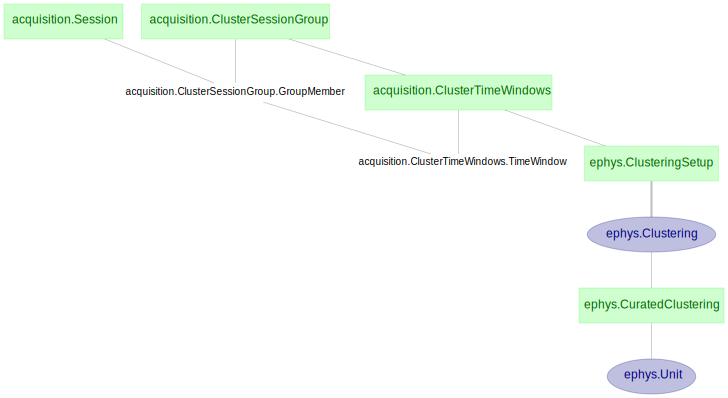

In [4]:
(dj.Diagram(acquisition.ClusterTimeWindows) - 1 
 + acquisition.Session + acquisition.ClusterSessionGroup.GroupMember
 + acquisition.ClusterTimeWindows.TimeWindow
 + ephys.Clustering + ephys.Unit)

### To demonstrate, let's create a new ClusterSessionGroup with the following 2 sessions from animal "25843"

In [5]:
acquisition.Session * animal.Animal & 'animal_name = "25843"'

animal_id,datasource_id,session_time start time of this session,session_note,animal_species,animal_name,animal_sex,animal_dob,color
40bfa03a7a7018cc,0,2019-09-17 19:43:06,=BLOB=,rat,25843,M,2019-06-19,None
40bfa03a7a7018cc,0,2019-09-27 15:50:36,=BLOB=,rat,25843,M,2019-06-19,None
40bfa03a7a7018cc,0,2019-09-27 18:36:56,=BLOB=,rat,25843,M,2019-06-19,None


Pick the 2 sessions on 2019-09-27 

In [6]:
session_keys = (acquisition.Session * animal.Animal & 'animal_name = "25843"'
                & 'session_time in ("2019-09-27 15:50:36", "2019-09-27 18:36:56")').fetch('KEY')

In [7]:
session_keys

[{'animal_id': '40bfa03a7a7018cc',
  'datasource_id': 0,
  'session_time': datetime.datetime(2019, 9, 27, 15, 50, 36)},
 {'animal_id': '40bfa03a7a7018cc',
  'datasource_id': 0,
  'session_time': datetime.datetime(2019, 9, 27, 18, 36, 56)}]

Quick recap on the structure of ClusterSessionGroup and GroupMember

In [8]:
acquisition.ClusterSessionGroup.describe();

group_name           : varchar(36)                  
---
group_desc=""        : varchar(128)                 



In [9]:
acquisition.ClusterSessionGroup.GroupMember.describe();

-> acquisition.ClusterSessionGroup
-> acquisition.Session



#### Adding ClusterSessionGroup and GroupMember

+ Create and insert a new cluster session group
+ Add the group members (those 2 sessions) for this new group

All in one transaction (this is important)

In [ ]:
sess_group = {'group_name': '25843_2019-09-27', 'group_desc': '2 sessions on 2019-09-27, for animal 25843'}
with acquisition.ClusterSessionGroup.connection.transaction:
    acquisition.ClusterSessionGroup.insert1(sess_group)
    acquisition.ClusterSessionGroup.GroupMember.insert([{**sess_group, **sess_key} 
                                                        for sess_key in session_keys], ignore_extra_fields=True)

In [10]:
acquisition.ClusterSessionGroup & {'group_name': '25843_2019-09-27'}

group_name,group_desc
25843_2019-09-27,"2 sessions on 2019-09-27, for animal 25843"


In [11]:
acquisition.ClusterSessionGroup.GroupMember & {'group_name': '25843_2019-09-27'}

group_name,animal_id,datasource_id,session_time start time of this session
25843_2019-09-27,40bfa03a7a7018cc,0,2019-09-27 15:50:36
25843_2019-09-27,40bfa03a7a7018cc,0,2019-09-27 18:36:56


#### Next, create time window(s) associated with the session

If the time windows of interest are simply the entire length of the session fo each session, then we can use the built-in helper function `acquisition.ClusterTimeWindows.insert_full_length_windows()`

In [ ]:
acquisition.ClusterTimeWindows().insert_full_length_windows({'group_name': '25843_2019-09-27'},
                                                            time_window_name='2019-09-27_full_window')

In [12]:
acquisition.ClusterTimeWindows & {'group_name': '25843_2019-09-27'}

group_name,time_window_name unique name for this window set,time_window_hash hash of all the part windows
25843_2019-09-27,2019-09-27_full_window,031717206c9304eb0f66180c83396774


In [13]:
acquisition.ClusterTimeWindows.TimeWindow & {'group_name': '25843_2019-09-27'}

group_name,time_window_name unique name for this window set,animal_id,datasource_id,session_time start time of this session,"window_start (s) onset of this window, with respect to this session onset","window_stop (s) offset of this window, with respect to this session onset"
25843_2019-09-27,2019-09-27_full_window,40bfa03a7a7018cc,0,2019-09-27 15:50:36,0.00,-1.0
25843_2019-09-27,2019-09-27_full_window,40bfa03a7a7018cc,0,2019-09-27 18:36:56,0.00,-1.0


The `time_window_hash` attribute ensures no new `ClusterTimeWindows` with identical time windows (and perhaps different `time_window_name`) can be inserted. Such attempt will result in error, see below

In [14]:
acquisition.ClusterTimeWindows().insert_full_length_windows({'group_name': '25843_2019-09-27'},
                                                            time_window_name='2019-09-27_full_window_22')

ValueError: The specified time window(s) already exists

## Next, adding a new clustering and curation results

Essentially, this step needs to make insertions into:
+ ephys.ClusteringSetup
+ ephys.Clustering
+ ephys.CuratedClustering

This is equivalent to making CuratedClustering request on the Web GUI. The Web GUI performs checks and makes those insertions for users, but only on default ClusterSessionGroup and TimeWindows, here we need to do it for the multi-session group ourselves.

Instead of submitting the request through the Web GUI, we need to submit the request - making an insert into the `ingestion.MultiSessCuratedClusteringRequest` table

In [15]:
ingestion.MultiSessCuratedClusteringRequest.describe();

-> acquisition.ClusterTimeWindows
curation_timestamps  : datetime                     # ensure complete datetime here to prevent collision (in the rare case of multiple people curate at the exact same datetime)
---
-> `group_shared_flask`.`users`
-> reference.Experimenter.proj(curator="experimenter")
curation_notes=""    : varchar(128)                 
curation_output_full_path : varchar(128)                 



As seen, this request requires information about:
+ the `ClusterTimeWindows`, so we can specify the one we created above
+ curation_timestamps
+ user - username making this request (i.e. the username used to log on to the Web GUI)
+ curator 
+ curation_notes
+ curation_output_full_path

In [ ]:
request = {'group_name': '25843_2019-09-27',
           'time_window_name': '2019-09-27_full_window',
           'username': 'testuser',
           'curation_timestamps': '2019-09-27 18:31:01',
           'curator': 'testuser',
           'curation_output_full_path': 'N:/sampledata/neuropixel/2019-09-27_18-37-01'}

Insert the request:

In [ ]:
ingestion.MultiSessCuratedClusteringRequest.insert1(request)

Once the request is inserted, the workers will pick up this request and start processing, once done, you can check the units, spiketimes, etc. as usual

### Checking for units

In [ ]:
time_window_key = {'group_name': '25843_2019-09-27',
 'time_window_name': '2019-09-27_full_window'}

In [ ]:
ephys.Unit & time_window_key

In [ ]:
ephys.SpikesTracking & time_window_key

In [16]:
sess_1 = session_keys[0]
sess_2 = session_keys[1]

In [17]:
ephys.SpikesTracking & sess_1

animal_id,datasource_id,insertion_time When this probe was inserted,group_name,time_window_name unique name for this window set,"cluster_param_name some unique name, ideally reflecting the method as well","probe_model nick name, or other user-friendly model name of this probe",electrode_config_id hash of the group and group_member (ensure uniqueness),sync_method sync method name,curation_timestamps ensure complete datetime here to prevent collision (in the rare case of multiple people curate at the exact same datetime),unit,session_time start time of this session,recording_time start time of this recording,tracking_time start time of this tracking recording,tracking_processing_method,spike_times (s) repeat of SyncedSpikeTimes (for convenient queries),speed (cm/s) tracked speed at each spike times (time relative to the start of session),x_pos (cm) tracked x-pos at each spike times (time relative to the start of session),y_pos (cm) tracked y-pos at each spike times (time relative to the start of session),z_pos (cm) tracked z-pos at each spike times (time relative to the start of session),head_yaw (degree) tracked head yaw at each spike times (time relative to the start of session),head_pitch (degree) tracked head pitch at each spike times (time relative to the start of session),head_roll (degree) tracked head roll at each spike times (time relative to the start of session),angular_speed (degree/s) tracked head angular speed at each spike times (time relative to the start of session),matched_spike_percent percentage of spike times well matched to tracking times (time differences less than 2.1*tracking_fs)
40bfa03a7a7018cc,0,2019-09-11 14:08:45,25843_2019-09-27,2019-09-27_full_window,default_kilosort,neuropixels_1.0,3bae3f7153f0305d02232efd41217754,linear_interp,2019-09-27 18:31:01,0,2019-09-27 15:50:36,2019-09-27 15:50:36,2019-09-27 15:50:08,3d_optitrack,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,99.9847
40bfa03a7a7018cc,0,2019-09-11 14:08:45,25843_2019-09-27,2019-09-27_full_window,default_kilosort,neuropixels_1.0,3bae3f7153f0305d02232efd41217754,linear_interp,2019-09-27 18:31:01,1,2019-09-27 15:50:36,2019-09-27 15:50:36,2019-09-27 15:50:08,3d_optitrack,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,99.9725
40bfa03a7a7018cc,0,2019-09-11 14:08:45,25843_2019-09-27,2019-09-27_full_window,default_kilosort,neuropixels_1.0,3bae3f7153f0305d02232efd41217754,linear_interp,2019-09-27 18:31:01,2,2019-09-27 15:50:36,2019-09-27 15:50:36,2019-09-27 15:50:08,3d_optitrack,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,99.9784
40bfa03a7a7018cc,0,2019-09-11 14:08:45,25843_2019-09-27,2019-09-27_full_window,default_kilosort,neuropixels_1.0,3bae3f7153f0305d02232efd41217754,linear_interp,2019-09-27 18:31:01,5,2019-09-27 15:50:36,2019-09-27 15:50:36,2019-09-27 15:50:08,3d_optitrack,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,99.981
40bfa03a7a7018cc,0,2019-09-11 14:08:45,25843_2019-09-27,2019-09-27_full_window,default_kilosort,neuropixels_1.0,3bae3f7153f0305d02232efd41217754,linear_interp,2019-09-27 18:31:01,6,2019-09-27 15:50:36,2019-09-27 15:50:36,2019-09-27 15:50:08,3d_optitrack,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,99.9231
40bfa03a7a7018cc,0,2019-09-11 14:08:45,25843_2019-09-27,2019-09-27_full_window,default_kilosort,neuropixels_1.0,3bae3f7153f0305d02232efd41217754,linear_interp,2019-09-27 18:31:01,7,2019-09-27 15:50:36,2019-09-27 15:50:36,2019-09-27 15:50:08,3d_optitrack,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,99.9793
40bfa03a7a7018cc,0,2019-09-11 14:08:45,25843_2019-09-27,2019-09-27_full_window,default_kilosort,neuropixels_1.0,3bae3f7153f0305d02232efd41217754,linear_interp,2019-09-27 18:31:01,8,2019-09-27 15:50:36,2019-09-27 15:50:36,2019-09-27 15:50:08,3d_optitrack,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,99.9638
40bfa03a7a7018cc,0,2019-09-11 14:08:45,25843_2019-09-27,2019-09-27_full_window,default_kilosort,

In [20]:
ephys.SpikesTracking & sess_1 & 'group_name = "25843_2019-09-27"'

animal_id,datasource_id,insertion_time When this probe was inserted,group_name,time_window_name unique name for this window set,"cluster_param_name some unique name, ideally reflecting the method as well","probe_model nick name, or other user-friendly model name of this probe",electrode_config_id hash of the group and group_member (ensure uniqueness),sync_method sync method name,curation_timestamps ensure complete datetime here to prevent collision (in the rare case of multiple people curate at the exact same datetime),unit,session_time start time of this session,recording_time start time of this recording,tracking_time start time of this tracking recording,tracking_processing_method,spike_times (s) repeat of SyncedSpikeTimes (for convenient queries),speed (cm/s) tracked speed at each spike times (time relative to the start of session),x_pos (cm) tracked x-pos at each spike times (time relative to the start of session),y_pos (cm) tracked y-pos at each spike times (time relative to the start of session),z_pos (cm) tracked z-pos at each spike times (time relative to the start of session),head_yaw (degree) tracked head yaw at each spike times (time relative to the start of session),head_pitch (degree) tracked head pitch at each spike times (time relative to the start of session),head_roll (degree) tracked head roll at each spike times (time relative to the start of session),angular_speed (degree/s) tracked head angular speed at each spike times (time relative to the start of session),matched_spike_percent percentage of spike times well matched to tracking times (time differences less than 2.1*tracking_fs)
40bfa03a7a7018cc,0,2019-09-11 14:08:45,25843_2019-09-27,2019-09-27_full_window,default_kilosort,neuropixels_1.0,3bae3f7153f0305d02232efd41217754,linear_interp,2019-09-27 18:31:01,0,2019-09-27 15:50:36,2019-09-27 15:50:36,2019-09-27 15:50:08,3d_optitrack,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,99.9847
40bfa03a7a7018cc,0,2019-09-11 14:08:45,25843_2019-09-27,2019-09-27_full_window,default_kilosort,neuropixels_1.0,3bae3f7153f0305d02232efd41217754,linear_interp,2019-09-27 18:31:01,1,2019-09-27 15:50:36,2019-09-27 15:50:36,2019-09-27 15:50:08,3d_optitrack,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,99.9725
40bfa03a7a7018cc,0,2019-09-11 14:08:45,25843_2019-09-27,2019-09-27_full_window,default_kilosort,neuropixels_1.0,3bae3f7153f0305d02232efd41217754,linear_interp,2019-09-27 18:31:01,2,2019-09-27 15:50:36,2019-09-27 15:50:36,2019-09-27 15:50:08,3d_optitrack,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,99.9784
40bfa03a7a7018cc,0,2019-09-11 14:08:45,25843_2019-09-27,2019-09-27_full_window,default_kilosort,neuropixels_1.0,3bae3f7153f0305d02232efd41217754,linear_interp,2019-09-27 18:31:01,5,2019-09-27 15:50:36,2019-09-27 15:50:36,2019-09-27 15:50:08,3d_optitrack,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,99.981
40bfa03a7a7018cc,0,2019-09-11 14:08:45,25843_2019-09-27,2019-09-27_full_window,default_kilosort,neuropixels_1.0,3bae3f7153f0305d02232efd41217754,linear_interp,2019-09-27 18:31:01,6,2019-09-27 15:50:36,2019-09-27 15:50:36,2019-09-27 15:50:08,3d_optitrack,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,99.9231
40bfa03a7a7018cc,0,2019-09-11 14:08:45,25843_2019-09-27,2019-09-27_full_window,default_kilosort,neuropixels_1.0,3bae3f7153f0305d02232efd41217754,linear_interp,2019-09-27 18:31:01,7,2019-09-27 15:50:36,2019-09-27 15:50:36,2019-09-27 15:50:08,3d_optitrack,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,99.9793
40bfa03a7a7018cc,0,2019-09-11 14:08:45,25843_2019-09-27,2019-09-27_full_window,default_kilosort,neuropixels_1.0,3bae3f7153f0305d02232efd41217754,linear_interp,2019-09-27 18:31:01,8,2019-09-27 15:50:36,2019-09-27 15:50:36,2019-09-27 15:50:08,3d_optitrack,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,99.9638
40bfa03a7a7018cc,0,2019-09-11 14:08:45,25843_2019-09-27,2019-09-27_full_window,default_kilosort,

## Using the `FavoriteSelection` table to filter for units

More detail on this `analysis_param.FavoriteSelection` feature is given in this [use-case example](Part_2_cell_analysis_results.ipynb) 

To start, let's add a ***Favorite Selection*** for yourself (note, one user only has one favorite selection at a time). You need to specify:
+ user: username/experimenter (basically yourself)
+ cell_analysis_method: your favorite cell_analysis_method
+ analysis_package: Python or MATLAB

In [21]:
analysis_param.FavoriteSelection.describe();

-> reference.Experimenter.proj(user="experimenter")
---
-> analysis_param.CellAnalysisMethod
-> analysis_param.AnalysisPackage



In [22]:
analysis_param.CellAnalysisMethod()

cell_analysis_method,cell_analysis_method_hash hash of the dictionary of the part params: with key as the table name (e.g. OccupancyParams) and value as the corresponding param hash (e.g. occu_params_hash),cell_analysis_description
method_default,d36a981bb53fd79b8e4fa03e8cd5c448,
testuser_method,31f072cc4b4bbf52a5198c05979d514c,


In [ ]:
analysis_param.FavoriteSelection.insert1({'user': 'testuser',
                                          'cell_analysis_method': 'testuser_method',
                                          'analysis_package': 'python'})

Now you can generate a restrictor for any subsequent queries, using the built-in `FavoriteSelection.get_restrictor()` method

In [23]:
help(analysis_param.FavoriteSelection().get_restrictor)

Help on method get_restrictor in module ephys.analysis_param:

get_restrictor(user, session_key=None, cluster_time_window=None) method of ephys.analysis_param.FavoriteSelection instance
    Return a restrictor (list of dict) with restriction criteria for the specified "user"
        and the FinalizedClustering for the specified "session_key"
    Note: the returned FinalizedClustering are for the ClusterTimeWindows key - specified in 'cluster_time_windows'
        If 'cluster_time_windows' not specified, then the returned FinalizedClustering
         are for the default ClusterTimeWindows for the specified session - 'session_key':
            i.e. single session and single time window spanning the entire session
    Example usage:
        analysis.GridScore & task_key & unit_key & analysis_param.FinalSelection().get_restrictor('davidcr', session_key=task_key)
        analysis.GridScore & task_key & unit_key & analysis_param.FinalSelection().get_restrictor('davidcr', cluster_time_window=

In [25]:
time_window_key = {'group_name': '25843_2019-09-27',
 'time_window_name': '2019-09-27_full_window'}

In [38]:
restrictor = analysis_param.FavoriteSelection().get_restrictor('testuser', cluster_time_window=time_window_key)

In [39]:
restrictor_s1 = analysis_param.FavoriteSelection().get_restrictor('testuser', session_key=sess_1)

In [27]:
restrictor

[{'user': 'testuser',
  'cell_analysis_method': 'testuser_method',
  'analysis_package': 'python',
  'shuffle_params_name': 'default',
  'score_params_name': 'default',
  'smoothing_params_name': 'default',
  'occu_params_name': 'default',
  'field_detect_params_name': 'default',
  'cell_selection_params_name': 'testuser',
  'animal_id': '40bfa03a7a7018cc',
  'datasource_id': 0,
  'insertion_time': datetime.datetime(2019, 9, 11, 14, 8, 45),
  'group_name': '25843_2019-09-27',
  'time_window_name': '2019-09-27_full_window',
  'cluster_param_name': 'default_kilosort',
  'probe_model': 'neuropixels_1.0',
  'electrode_config_id': '3bae3f7153f0305d02232efd41217754',
  'sync_method': 'linear_interp',
  'curation_timestamps': datetime.datetime(2019, 9, 27, 18, 31, 1)},
 {'user': 'testuser',
  'cell_analysis_method': 'testuser_method',
  'analysis_package': 'python',
  'shuffle_params_name': 'default',
  'score_params_name': 'default',
  'smoothing_params_name': 'default',
  'occu_params_name'

In [40]:
ephys.Unit & restrictor

animal_id,datasource_id,insertion_time When this probe was inserted,group_name,time_window_name unique name for this window set,"cluster_param_name some unique name, ideally reflecting the method as well","probe_model nick name, or other user-friendly model name of this probe",electrode_config_id hash of the group and group_member (ensure uniqueness),sync_method sync method name,curation_timestamps ensure complete datetime here to prevent collision (in the rare case of multiple people curate at the exact same datetime),unit,electrode_group electrode group,electrode electrode,cluster_type
40bfa03a7a7018cc,0,2019-09-11 14:08:45,25843_2019-09-27,2019-09-27_full_window,default_kilosort,neuropixels_1.0,3bae3f7153f0305d02232efd41217754,linear_interp,2019-09-27 18:31:01,0,0,1,good
40bfa03a7a7018cc,0,2019-09-11 14:08:45,25843_2019-09-27,2019-09-27_full_window,default_kilosort,neuropixels_1.0,3bae3f7153f0305d02232efd41217754,linear_interp,2019-09-27 18:31:01,1,0,2,good
40bfa03a7a7018cc,0,2019-09-11 14:08:45,25843_2019-09-27,2019-09-27_full_window,default_kilosort,neuropixels_1.0,3bae3f7153f0305d02232efd41217754,linear_interp,2019-09-27 18:31:01,2,0,7,good
40bfa03a7a7018cc,0,2019-09-11 14:08:45,25843_2019-09-27,2019-09-27_full_window,default_kilosort,neuropixels_1.0,3bae3f7153f0305d02232efd41217754,linear_interp,2019-09-27 18:31:01,3,0,5,noise
40bfa03a7a7018cc,0,2019-09-11 14:08:45,25843_2019-09-27,2019-09-27_full_window,default_kilosort,neuropixels_1.0,3bae3f7153f0305d02232efd41217754,linear_interp,2019-09-27 18:31:01,4,0,5,noise
40bfa03a7a7018cc,0,2019-09-11 14:08:45,25843_2019-09-27,2019-09-27_full_window,default_kilosort,neuropixels_1.0,3bae3f7153f0305d02232efd41217754,linear_interp,2019-09-27 18:31:01,5,0,7,good
40bfa03a7a7018cc,0,2019-09-11 14:08:45,25843_2019-09-27,2019-09-27_full_window,default_kilosort,neuropixels_1.0,3bae3f7153f0305d02232efd41217754,linear_interp,2019-09-27 18:31:01,6,0,27,good
40bfa03a7a7018cc,0,2019-09-11 14:08:45,25843_2019-09-27,2019-09-27_full_window,default_kilosort,neuropixels_1.0,3bae3f7153f0305d02232efd41217754,linear_interp,2019-09-27 18:31:01,7,0,9,good
40bfa03a7a7018cc,0,2019-09-11 14:08:45,25843_2019-09-27,2019-09-27_full_window,default_kilosort,neuropixels_1.0,3bae3f7153f0305d02232efd41217754,linear_interp,2019-09-27 18:31:01,8,0,7,good
40bfa03a7a7018cc,0,2019-09-11 14:08:45,25843_2019-09-27,2019-09-27_full_window,default_kilosort,neuropixels_1.0,3bae3f7153f0305d02232efd41217754,linear_interp,2019-09-27 18:31:01,9,0,9,good


In [41]:
ephys.Unit & restrictor_s1

animal_id,datasource_id,insertion_time When this probe was inserted,group_name,time_window_name unique name for this window set,"cluster_param_name some unique name, ideally reflecting the method as well","probe_model nick name, or other user-friendly model name of this probe",electrode_config_id hash of the group and group_member (ensure uniqueness),sync_method sync method name,curation_timestamps ensure complete datetime here to prevent collision (in the rare case of multiple people curate at the exact same datetime),unit,electrode_group electrode group,electrode electrode,cluster_type
40bfa03a7a7018cc,0,2019-09-11 14:08:45,det_5ee341d9c705edcb522ab1ac3902087f,full_adc986ac2c583faf,default_kilosort,neuropixels_1.0,3bae3f7153f0305d02232efd41217754,linear_interp,2019-09-27 12:11:36,0,0,15,noise
40bfa03a7a7018cc,0,2019-09-11 14:08:45,det_5ee341d9c705edcb522ab1ac3902087f,full_adc986ac2c583faf,default_kilosort,neuropixels_1.0,3bae3f7153f0305d02232efd41217754,linear_interp,2019-09-27 12:11:36,1,0,15,noise
40bfa03a7a7018cc,0,2019-09-11 14:08:45,det_5ee341d9c705edcb522ab1ac3902087f,full_adc986ac2c583faf,default_kilosort,neuropixels_1.0,3bae3f7153f0305d02232efd41217754,linear_interp,2019-09-27 12:11:36,2,0,15,noise
40bfa03a7a7018cc,0,2019-09-11 14:08:45,det_5ee341d9c705edcb522ab1ac3902087f,full_adc986ac2c583faf,default_kilosort,neuropixels_1.0,3bae3f7153f0305d02232efd41217754,linear_interp,2019-09-27 12:11:36,3,0,15,noise
40bfa03a7a7018cc,0,2019-09-11 14:08:45,det_5ee341d9c705edcb522ab1ac3902087f,full_adc986ac2c583faf,default_kilosort,neuropixels_1.0,3bae3f7153f0305d02232efd41217754,linear_interp,2019-09-27 12:11:36,4,0,29,good
40bfa03a7a7018cc,0,2019-09-11 14:08:45,det_5ee341d9c705edcb522ab1ac3902087f,full_adc986ac2c583faf,default_kilosort,neuropixels_1.0,3bae3f7153f0305d02232efd41217754,linear_interp,2019-09-27 12:11:36,5,0,29,noise
40bfa03a7a7018cc,0,2019-09-11 14:08:45,det_5ee341d9c705edcb522ab1ac3902087f,full_adc986ac2c583faf,default_kilosort,neuropixels_1.0,3bae3f7153f0305d02232efd41217754,linear_interp,2019-09-27 12:11:36,6,0,15,noise
40bfa03a7a7018cc,0,2019-09-11 14:08:45,det_5ee341d9c705edcb522ab1ac3902087f,full_adc986ac2c583faf,default_kilosort,neuropixels_1.0,3bae3f7153f0305d02232efd41217754,linear_interp,2019-09-27 12:11:36,7,0,31,good
40bfa03a7a7018cc,0,2019-09-11 14:08:45,det_5ee341d9c705edcb522ab1ac3902087f,full_adc986ac2c583faf,default_kilosort,neuropixels_1.0,3bae3f7153f0305d02232efd41217754,linear_interp,2019-09-27 12:11:36,8,0,38,good
40bfa03a7a7018cc,0,2019-09-11 14:08:45,det_5ee341d9c705edcb522ab1ac3902087f,full_adc986ac2c583faf,default_kilosort,neuropixels_1.0,3bae3f7153f0305d02232efd41217754,linear_interp,2019-09-27 12:11:36,9,0,38,noise


Let's look at some task-specific results. Pick a task first

In [28]:
q_tasks = behavior.Task & (acquisition.ClusterSessionGroup.GroupMember & time_window_key)

In [29]:
q_tasks

animal_id,datasource_id,session_time start time of this session,task_type,task_start (s) timestamp of task onset with respect to the start of the session,task_stop (s) timestamp of task offset with respect to the start of the session,arena_apparatus,task_light_level
40bfa03a7a7018cc,0,2019-09-27 15:50:36,OpenField,78.00,5121.00,Megaspace,None
40bfa03a7a7018cc,0,2019-09-27 15:50:36,OpenField,6742.00,8566.00,square_150,None
40bfa03a7a7018cc,0,2019-09-27 18:36:56,open_field_1,3823.00,6013.00,Megaspace,None
40bfa03a7a7018cc,0,2019-09-27 18:36:56,sleep_box_1,26.00,3684.00,Megaspace,None


In [42]:
task = q_tasks.fetch('KEY')[0]

In [43]:
analysis.TaskSpikesTracking & task & restrictor

animal_id,datasource_id,session_time start time of this session,task_type,task_start (s) timestamp of task onset with respect to the start of the session,insertion_time When this probe was inserted,group_name,time_window_name unique name for this window set,"cluster_param_name some unique name, ideally reflecting the method as well","probe_model nick name, or other user-friendly model name of this probe",electrode_config_id hash of the group and group_member (ensure uniqueness),sync_method sync method name,curation_timestamps ensure complete datetime here to prevent collision (in the rare case of multiple people curate at the exact same datetime),unit,cell_selection_params_name user-friendly name,spike_times (s) task-related spike times (time with respect to the start of the task),speed (cm/s) task-related speed at each spike times,x_pos (cm) task-related x-pos at each spike times,y_pos (cm) task-related y-pos at each spike times,z_pos (cm) task-related z-pos at each spike times,head_yaw (degree) task-related head yaw (left/right angle) at each spike times,head_pitch (degree) task-related head pitch (up/down) at each spike times,head_roll (degree) task-related head roll (clockwise/anticlockwise) at each spike times,angular_speed (degree/s) task-related head angular speed at each spike times
40bfa03a7a7018cc,0,2019-09-27 15:50:36,OpenField,78.00,2019-09-11 14:08:45,25843_2019-09-27,2019-09-27_full_window,default_kilosort,neuropixels_1.0,3bae3f7153f0305d02232efd41217754,linear_interp,2019-09-27 18:31:01,0,testuser,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
40bfa03a7a7018cc,0,2019-09-27 15:50:36,OpenField,78.00,2019-09-11 14:08:45,25843_2019-09-27,2019-09-27_full_window,default_kilosort,neuropixels_1.0,3bae3f7153f0305d02232efd41217754,linear_interp,2019-09-27 18:31:01,1,testuser,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
40bfa03a7a7018cc,0,2019-09-27 15:50:36,OpenField,78.00,2019-09-11 14:08:45,25843_2019-09-27,2019-09-27_full_window,default_kilosort,neuropixels_1.0,3bae3f7153f0305d02232efd41217754,linear_interp,2019-09-27 18:31:01,2,testuser,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
40bfa03a7a7018cc,0,2019-09-27 15:50:36,OpenField,78.00,2019-09-11 14:08:45,25843_2019-09-27,2019-09-27_full_window,default_kilosort,neuropixels_1.0,3bae3f7153f0305d02232efd41217754,linear_interp,2019-09-27 18:31:01,5,testuser,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
40bfa03a7a7018cc,0,2019-09-27 15:50:36,OpenField,78.00,2019-09-11 14:08:45,25843_2019-09-27,2019-09-27_full_window,default_kilosort,neuropixels_1.0,3bae3f7153f0305d02232efd41217754,linear_interp,2019-09-27 18:31:01,6,testuser,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
40bfa03a7a7018cc,0,2019-09-27 15:50:36,OpenField,78.00,2019-09-11 14:08:45,25843_2019-09-27,2019-09-27_full_window,default_kilosort,neuropixels_1.0,3bae3f7153f0305d02232efd41217754,linear_interp,2019-09-27 18:31:01,7,testuser,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
40bfa03a7a7018cc,0,2019-09-27 15:50:36,OpenField,78.00,2019-09-11 14:08:45,25843_2019-09-27,2019-09-27_full_window,default_kilosort,neuropixels_1.0,3bae3f7153f0305d02232efd41217754,linear_interp,2019-09-27 18:31:01,8,testuser,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
40bfa03a7a7018cc,0,2019-09-27 15:50:36,OpenField,78.00,2019-09-11 14:08:45,25843_2019-09-27,2019-09-27_full_window,default_kilosort,neuropixels_1.0,3bae3f7153f0305d02232efd41217754,linear_interp,2019-09-27 18:31:01,9,testuser,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
40bfa03a7a7018cc,0,2019-09-27 15:50:36,OpenField,78.00,2019-09-11 14:08:45,25843_2019-09-27,2019-09-27_full_window,default_kilosort,neuropixels_1.0,3bae3f7153f0305d02232efd41217754,linear_interp,2019-09-27 18:31:01,11,testuser,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
40bfa03a7a7018cc,0,2019-09-27 15:50:36,OpenField,78.00,2019-09-11 14:08:45,25843_2019-

In [46]:
analysis.TaskSpikesTracking & task

animal_id,datasource_id,session_time start time of this session,task_type,task_start (s) timestamp of task onset with respect to the start of the session,insertion_time When this probe was inserted,group_name,time_window_name unique name for this window set,"cluster_param_name some unique name, ideally reflecting the method as well","probe_model nick name, or other user-friendly model name of this probe",electrode_config_id hash of the group and group_member (ensure uniqueness),sync_method sync method name,curation_timestamps ensure complete datetime here to prevent collision (in the rare case of multiple people curate at the exact same datetime),unit,cell_selection_params_name user-friendly name,spike_times (s) task-related spike times (time with respect to the start of the task),speed (cm/s) task-related speed at each spike times,x_pos (cm) task-related x-pos at each spike times,y_pos (cm) task-related y-pos at each spike times,z_pos (cm) task-related z-pos at each spike times,head_yaw (degree) task-related head yaw (left/right angle) at each spike times,head_pitch (degree) task-related head pitch (up/down) at each spike times,head_roll (degree) task-related head roll (clockwise/anticlockwise) at each spike times,angular_speed (degree/s) task-related head angular speed at each spike times
40bfa03a7a7018cc,0,2019-09-27 15:50:36,OpenField,78.00,2019-09-11 14:08:45,25843_2019-09-27,2019-09-27_full_window,default_kilosort,neuropixels_1.0,3bae3f7153f0305d02232efd41217754,linear_interp,2019-09-27 18:31:01,0,testuser,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
40bfa03a7a7018cc,0,2019-09-27 15:50:36,OpenField,78.00,2019-09-11 14:08:45,25843_2019-09-27,2019-09-27_full_window,default_kilosort,neuropixels_1.0,3bae3f7153f0305d02232efd41217754,linear_interp,2019-09-27 18:31:01,1,testuser,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
40bfa03a7a7018cc,0,2019-09-27 15:50:36,OpenField,78.00,2019-09-11 14:08:45,25843_2019-09-27,2019-09-27_full_window,default_kilosort,neuropixels_1.0,3bae3f7153f0305d02232efd41217754,linear_interp,2019-09-27 18:31:01,2,testuser,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
40bfa03a7a7018cc,0,2019-09-27 15:50:36,OpenField,78.00,2019-09-11 14:08:45,25843_2019-09-27,2019-09-27_full_window,default_kilosort,neuropixels_1.0,3bae3f7153f0305d02232efd41217754,linear_interp,2019-09-27 18:31:01,5,testuser,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
40bfa03a7a7018cc,0,2019-09-27 15:50:36,OpenField,78.00,2019-09-11 14:08:45,25843_2019-09-27,2019-09-27_full_window,default_kilosort,neuropixels_1.0,3bae3f7153f0305d02232efd41217754,linear_interp,2019-09-27 18:31:01,6,testuser,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
40bfa03a7a7018cc,0,2019-09-27 15:50:36,OpenField,78.00,2019-09-11 14:08:45,25843_2019-09-27,2019-09-27_full_window,default_kilosort,neuropixels_1.0,3bae3f7153f0305d02232efd41217754,linear_interp,2019-09-27 18:31:01,7,testuser,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
40bfa03a7a7018cc,0,2019-09-27 15:50:36,OpenField,78.00,2019-09-11 14:08:45,25843_2019-09-27,2019-09-27_full_window,default_kilosort,neuropixels_1.0,3bae3f7153f0305d02232efd41217754,linear_interp,2019-09-27 18:31:01,8,testuser,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
40bfa03a7a7018cc,0,2019-09-27 15:50:36,OpenField,78.00,2019-09-11 14:08:45,25843_2019-09-27,2019-09-27_full_window,default_kilosort,neuropixels_1.0,3bae3f7153f0305d02232efd41217754,linear_interp,2019-09-27 18:31:01,9,testuser,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
40bfa03a7a7018cc,0,2019-09-27 15:50:36,OpenField,78.00,2019-09-11 14:08:45,25843_2019-09-27,2019-09-27_full_window,default_kilosort,neuropixels_1.0,3bae3f7153f0305d02232efd41217754,linear_interp,2019-09-27 18:31:01,11,testuser,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
40bfa03a7a7018cc,0,2019-09-27 15:50:36,OpenField,78.00,2019-09-11 14:08:45,25843_2019-

Pick a probe, and a unit on that probe

In [32]:
q_probes = acquisition.ProbeInsertion & (ephys.Unit & restrictor)

In [33]:
q_probes

animal_id,datasource_id,insertion_time When this probe was inserted,probe unique identifier of this probe (e.g. serial number),insertion_note some notes
40bfa03a7a7018cc,0,2019-09-11 14:08:45,Neuropixel_1,Roger 1
40bfa03a7a7018cc,0,2019-09-11 14:09:22,Neuropixel_2,Roger 2


In [34]:
probe_1, probe_2 = q_probes.fetch('KEY')

In [35]:
analysis.TaskSpikesTracking & task & probe_1 & 'unit = 11' & restrictor 

animal_id,datasource_id,session_time start time of this session,task_type,task_start (s) timestamp of task onset with respect to the start of the session,insertion_time When this probe was inserted,group_name,time_window_name unique name for this window set,"cluster_param_name some unique name, ideally reflecting the method as well","probe_model nick name, or other user-friendly model name of this probe",electrode_config_id hash of the group and group_member (ensure uniqueness),sync_method sync method name,curation_timestamps ensure complete datetime here to prevent collision (in the rare case of multiple people curate at the exact same datetime),unit,cell_selection_params_name user-friendly name,spike_times (s) task-related spike times (time with respect to the start of the task),speed (cm/s) task-related speed at each spike times,x_pos (cm) task-related x-pos at each spike times,y_pos (cm) task-related y-pos at each spike times,z_pos (cm) task-related z-pos at each spike times,head_yaw (degree) task-related head yaw (left/right angle) at each spike times,head_pitch (degree) task-related head pitch (up/down) at each spike times,head_roll (degree) task-related head roll (clockwise/anticlockwise) at each spike times,angular_speed (degree/s) task-related head angular speed at each spike times
40bfa03a7a7018cc,0,2019-09-27 18:36:56,open_field_1,3823.00,2019-09-11 14:08:45,25843_2019-09-27,2019-09-27_full_window,default_kilosort,neuropixels_1.0,3bae3f7153f0305d02232efd41217754,linear_interp,2019-09-27 18:31:01,11,testuser,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=


In [48]:
analysis.RateMap * analysis.TaskSpikesTrackingProxy & task & probe_1 & 'unit = 11' & restrictor 

animal_id animal,datasource_id animal,session_time start time of this session,unit unit id,task_type,task_start (s) timestamp of task onset with respect to the start of the session,task_spike_tracking_hash hash of the TaskSpikesTracking primary_key,"occu_params_name Parameter set ID, starting with 'default'",smoothing_params_name,analysis_package,cell_selection_params_name user-friendly name,"field_detect_params_name Field detection method name, starting with A",ratemap Smoothed 2D ratemap # 1 map.z,ratemap_mask Mask (where time = 0) # 1 isnan(map.zRaw),ratemap_raw Unsmoothed ratemap # 1 map.zRaw,fieldmap 2 fieldsMap,field_quantity 2 size(fields),peak_rate,mean_rate 4,spatial_information_rate 3 information.rate,spatial_information_content 3 information.content,spatial_coherence 5 coherence,selectivity 3 selectivity,sparsity 5 sparsity,insertion_time When this probe was inserted,group_name,time_window_name unique name for this window set,"cluster_param_name some unique name, ideally reflecting the method as well","probe_model nick name, or other user-friendly model name of this probe",electrode_config_id hash of the group and group_member (ensure uniqueness),sync_method sync method name,curation_timestamps ensure complete datetime here to prevent collision (in the rare case of multiple people curate at the exact same datetime)
40bfa03a7a7018cc,0,2019-09-27 15:50:36,11,OpenField,78.00,9aa7e007bb6ef1468b0686dc06c1fa09,default,default,python,testuser,default,=BLOB=,=BLOB=,=BLOB=,=BLOB=,117,6476.87,32.5971,110.646,2.68106,0.197723,156.942,0.031747,2019-09-11 14:08:45,25843_2019-09-27,2019-09-27_full_window,default_kilosort,neuropixels_1.0,3bae3f7153f0305d02232efd41217754,linear_interp,2019-09-27 18:31:01


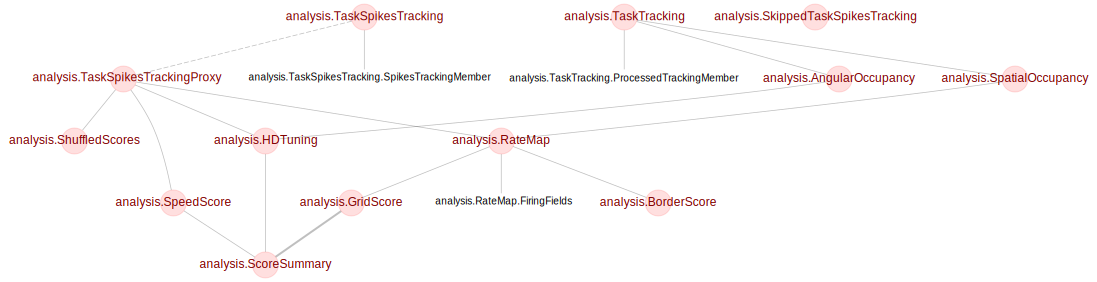

In [52]:
dj.Diagram(analysis)

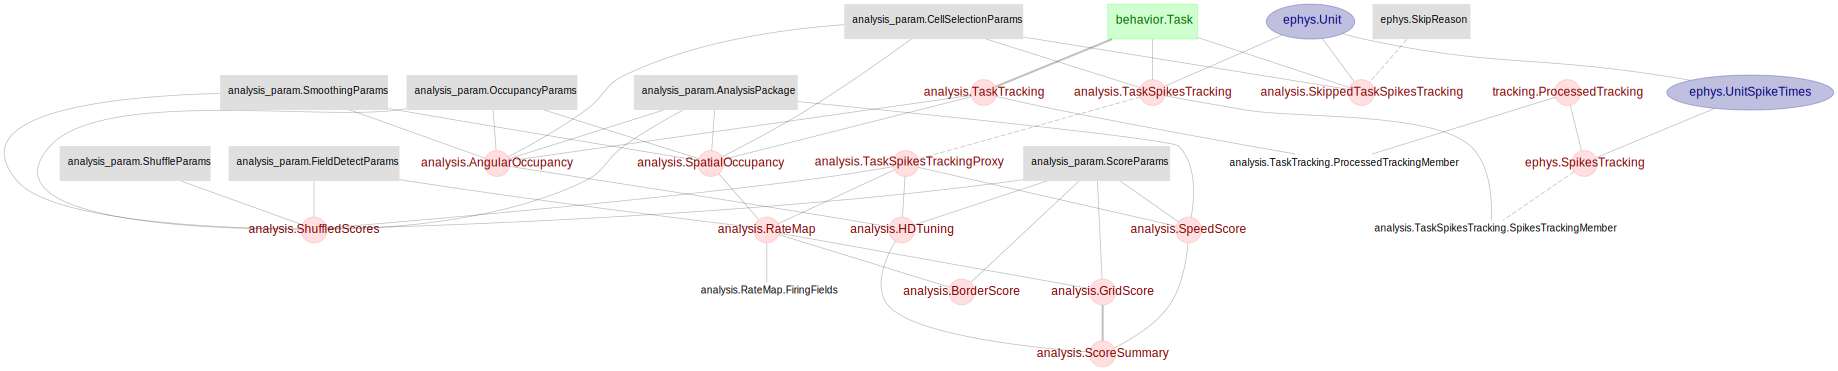

In [51]:
dj.Diagram(analysis) - 1